# Nicolaus Copernicus University summer internship project 
## Natural Language Processing applied to ancient language texts: author recognition 

This is the second part of our work.

We aim to find similarities between Anonymous Gallus and other known authors.


In [ ]:
#Install the necessary libraries
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti" -O latin_bert.tar && rm -f /tmp/cookies.txt
!mkdir models
!mv latin_bert.tar models/
!cd models
!tar -xf models/latin_bert.tar
!git clone https://github.com/pietro-sillano/LatinBERT LatinBERT
!pip install cltk==1.0.16
!pip install pygame  beautifulsoup4==4.9.1 cltk nltk==3.6.2 future==0.18.2 numpy tensor2tensor PyYAML==5.4.1 tokenizers==0.8.1rc2 transformers==3.1.0 tqdm==4.48.2 Unidecode==1.1.1 gensim==3.8.3
!pip install --upgrade scikit-learn
!pip install --upgrade spacy
!pip install --upgrade spacy
!pip install umap-learn
!pip install umap-learn[plot]

--2021-08-10 13:47:08--  https://docs.google.com/uc?export=download&confirm=yk&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti
Resolving docs.google.com (docs.google.com)... 108.177.97.101, 108.177.97.113, 108.177.97.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘latin_bert.tar’

latin_bert.tar          [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-08-10 13:47:08 (36.2 MB/s) - ‘latin_bert.tar’ saved [3301]

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors
Cloning into 'LatinBERT'...
remote: Enumerating objects: 3300, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 3300 (delta 76), reused 379 (delta 75), pack-reused 2920
Receiving objects: 100% (3300/3300), 407.11 MiB | 12.75 MiB/s, done.
Resolving del

In [ ]:
#Import the necessary libraries
import re
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import sys
import os
import umap
import umap.plot
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
source='/content/LatinBERT/pickle'
auth=[]
vector=[]
sentence=[]
for file in os.listdir(source):
    dbfile = open(source+'/'+file,'rb')     
    db = pickle.load(dbfile)
    for i in range(len(db.keys())):
        auth.append(str(db[i][0]).replace('corpus2/',''))
        vector.append(db[i][2])
        sentence.append(str(db[i][1]).replace('[CLS]','').replace('[SEP]',''))
X=np.array(vector)
np.shape(X)

(35472, 768)

In [ ]:
y=np.array(auth)

We compute kmean centroids and the similarity matrix

In [ ]:
indexes = np.unique(y, return_index=True)[1]
auth_un=[y[index] for index in sorted(indexes)]

In [ ]:
#we consider the k_means centers
kmeans = KMeans(n_clusters=len(auth_un), random_state=105).fit(X)
cen=kmeans.cluster_centers_
np.shape(cen)

(22, 768)

In [ ]:
cos=pd.DataFrame(metrics.pairwise.cosine_similarity(cen))

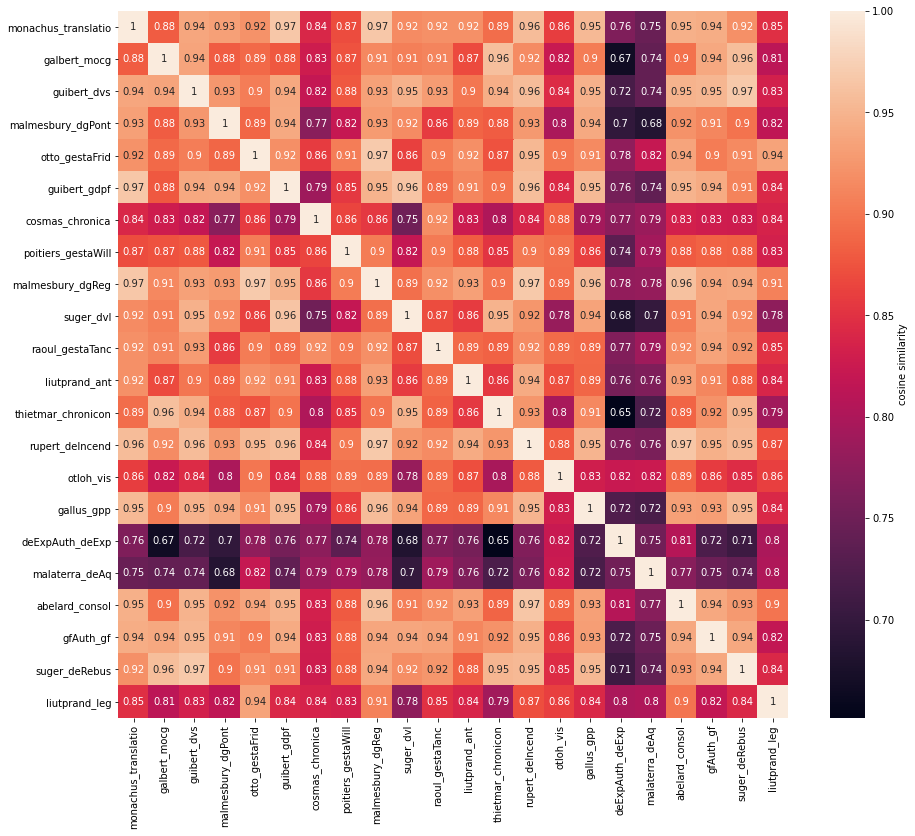

In [ ]:
plt.figure(figsize=(15,13))
sns.heatmap(cos,cbar_kws={'label': 'cosine similarity'}, xticklabels=auth_un,yticklabels=auth_un, annot=True)

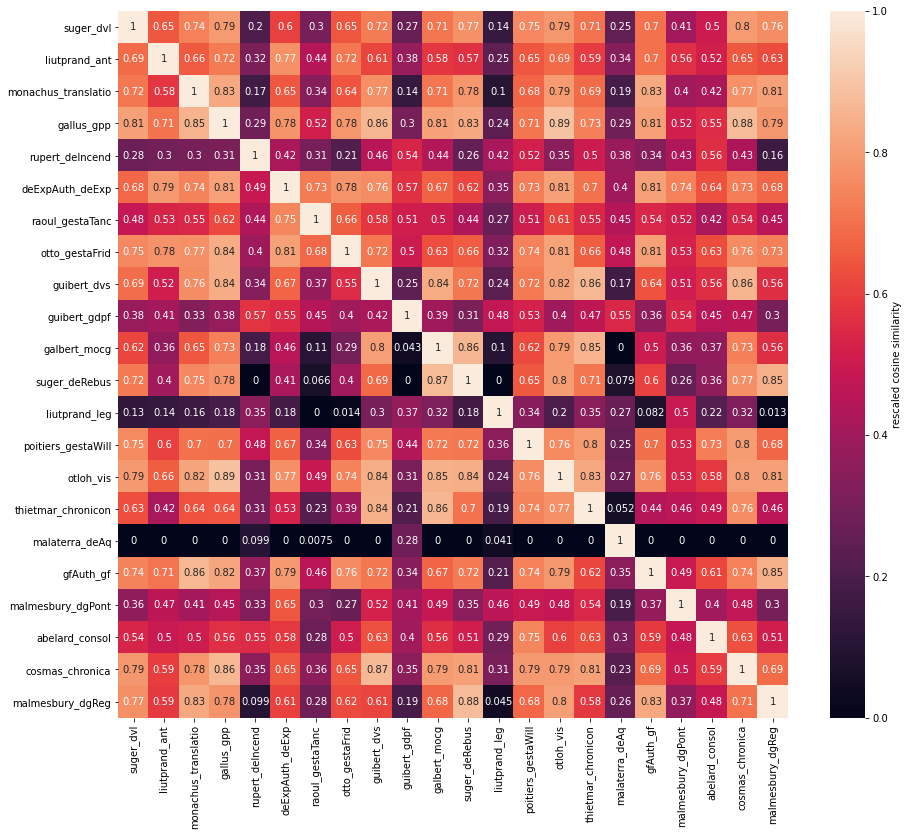

In [ ]:
#rescale
cos=MinMaxScaler().fit_transform(cos)
plt.figure(figsize=(15,13))
sns.heatmap(cos,vmin=0, vmax=1 ,cbar_kws={'label': 'rescaled cosine similarity'}, xticklabels=auth_un,yticklabels=auth_un, annot=True)

We also try a network representation

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


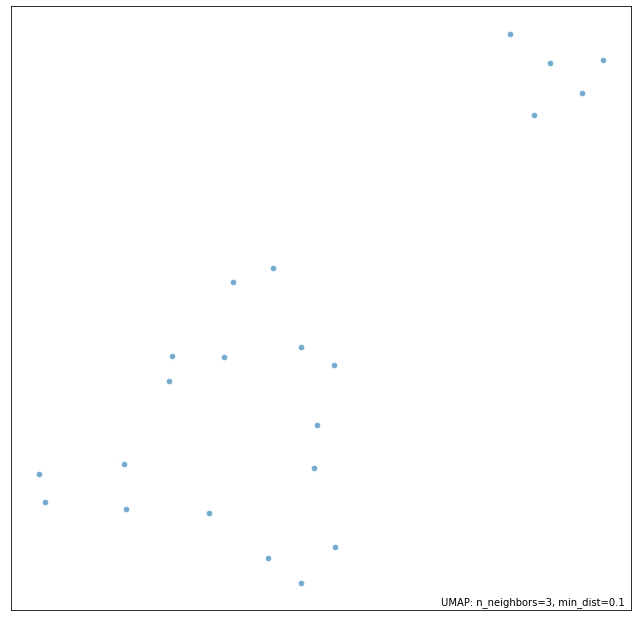

In [ ]:
#dimensionality reduction with UMAP and graphical representation 
mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.1, metric='euclidean', n_neighbors=3).fit(cen)
#position - the same as umap
p=mapper.transform(cen)
#plot
umap.plot.points(mapper)

In [ ]:
#Prepare the edge fro the network
li=[]
col=[]

N=np.shape(cos)[0]

for i in range(N):
    for j in range(N):
      if cos[i][j]!=0:
        li.append([i,j,cos[i][j]])

for i in range(len(li)):
    col.append(li[i][2])

G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

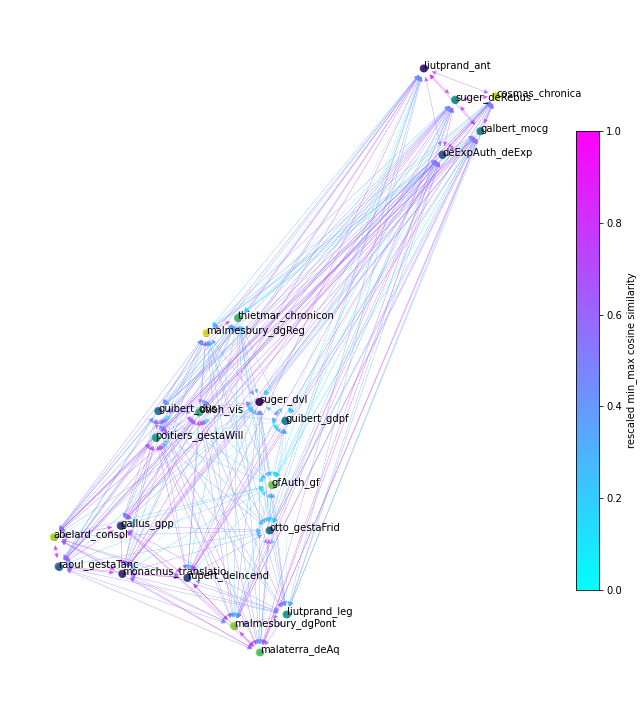

In [ ]:
#Plotting network with colormap based on cosine similarity
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(cos))
vmax = np.max(np.array(cos))

edge=nx.draw_networkx_edges(G1, p, alpha=0.8, edge_color=col, width=0.2,  edge_vmin=vmin, edge_vmax=vmax, edge_cmap=plt.cm.cool) 

nx.draw_networkx_nodes(G1, p, node_size=50.0, node_color=range(np.shape(cos)[0]), alpha=0.8)  


sm = plt.cm.ScalarMappable(cmap=plt.cm.cool) #, norm=plt.Normalize(vmin=vmin, vmax=vmax)
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="rescaled min_max cosine similarity")

plt.scatter(p[:,0], p[:,1])
n=auth_un
for i, txt in enumerate(n):
    plt.annotate(txt, (p[i,0], p[i,1]))

plt.axis('off')
plt.show()

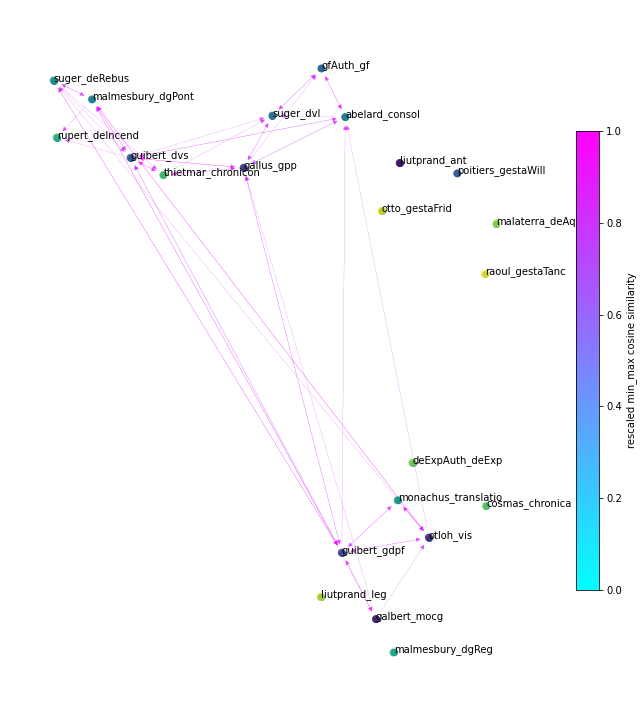

In [ ]:
#setting a cutoff
cos[cos < .8] = 0
li=[]
col=[]

N=np.shape(cos)[0]

for i in range(N):
    for j in range(N):
      if cos[i][j]!=0:
        li.append([i,j,cos[i][j]])

for i in range(len(li)):
    col.append(li[i][2])

G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

#Plotting network with colormap based on cosine similarity
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(cos))
vmax = np.max(np.array(cos))

edge=nx.draw_networkx_edges(G1, p, alpha=0.8, edge_color=col, width=0.2,  edge_vmin=vmin, edge_vmax=vmax, edge_cmap=plt.cm.cool) 

nx.draw_networkx_nodes(G1, p, node_size=50.0, node_color=range(np.shape(cos)[0]), alpha=0.8)  


sm = plt.cm.ScalarMappable(cmap=plt.cm.cool) #, norm=plt.Normalize(vmin=vmin, vmax=vmax)
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="rescaled min_max cosine similarity")

plt.scatter(p[:,0], p[:,1])
n=auth_un
for i, txt in enumerate(n):
    plt.annotate(txt, (p[i,0], p[i,1]))

plt.axis('off')
plt.show()